In [33]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Przygotowanie danych + Wizualizacja

Załadowanie zbioru danych i podział na zbiory testowy/treningowy. Wizualizacja po redukcji wymiarowości T-SNE

In [6]:
df = pd.read_csv("dataset/diabetes.csv")

In [7]:
df = df.fillna(df.mean()).astype({
    "Pregnancies": "int32",
    "Glucose": "int32",
    "BloodPressure": "int32",
    "SkinThickness": "int32",
    "Insulin": "int32",
    "BMI": "int32",
    "DiabetesPedigreeFunction": "float",
    "Age": "int32",
    "Outcome": "category"
})

In [8]:
y_cols = ["Outcome"]
feature_cols = df.columns.difference(y_cols)
X = df[feature_cols].values
y = df[y_cols].values
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X).astype(np.float32)
X_normalized.shape, y.shape


((768, 8), (768, 1))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=2138)

In [10]:
# 2dim T-SNE
tsne = TSNE(n_components=2, random_state=1356)
vis_points = tsne.fit_transform(X_train)

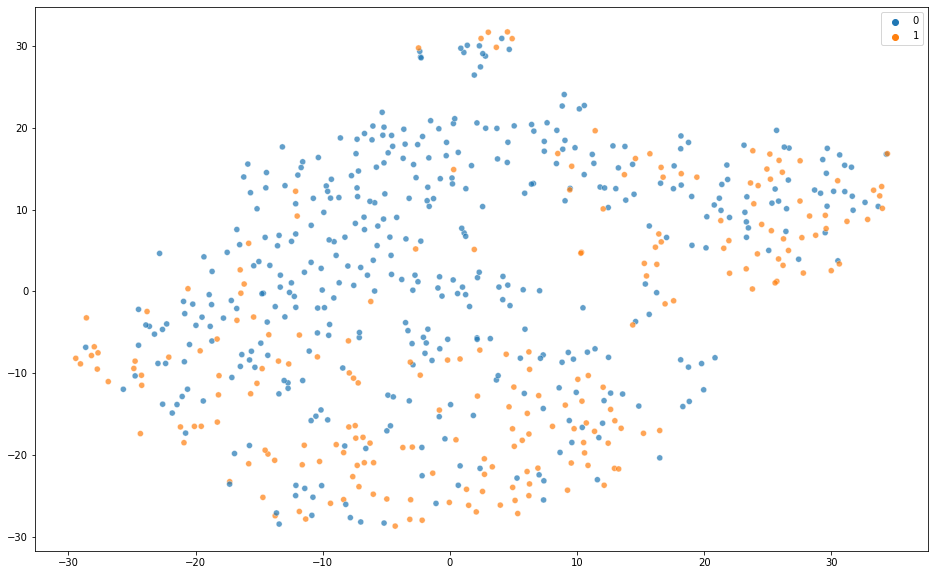

In [11]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=vis_points[:,0], y=vis_points[:,1], hue=y_train.ravel(), legend="full", alpha=0.7
)
plt.show()

In [12]:
# 3dim T-SNE
tsne = TSNE(n_components=3, random_state=1337)
vis_points = tsne.fit_transform(X_train)

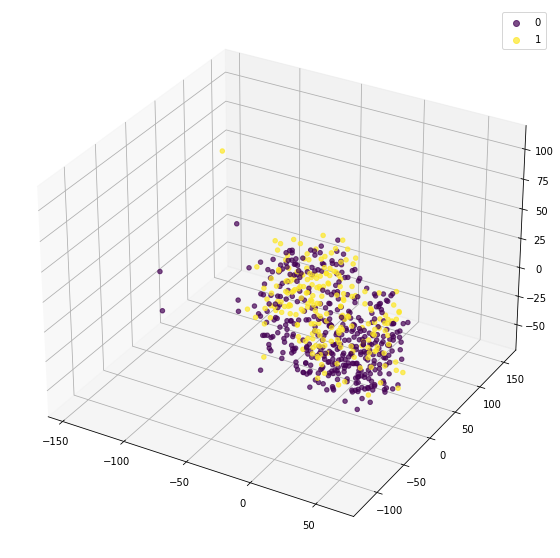

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(vis_points[:, 0], vis_points[:, 1], vis_points[:, 2], c=y_train, marker='o', alpha=0.7)
plt.legend(*sc.legend_elements())
plt.show()

## GMM 

### Podejscie pierwsze 

2 składowe odpowiadające klasom

In [34]:
from src.gmm import GaussianMixtureModel, GaussianMixtureModelKMeans

  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.


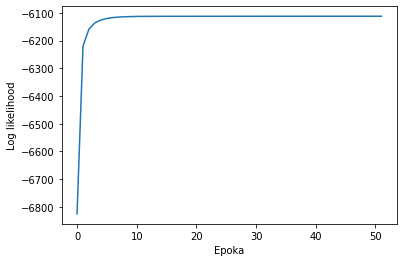

In [15]:
k = 2
n_dims = X_train.shape[1]
model = GaussianMixtureModelKMeans(n_components = k, n_dims = n_dims, n_epochs=100)
model.fit(X_train, random_state=42)

In [16]:
y_pred_probs = model.predict(X_test.astype(np.float32)).numpy()
# potrzeba sprawdzic 2 przypadki, bo nie wiemy które klastry odpowiadają której klasie
y_pred_1 = np.argmax(y_pred_probs, axis=1)
y_pred_2 = np.argmax(np.flip(y_pred_probs, axis=1), axis=1)

In [17]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.48      0.37      0.42        99
           1       0.19      0.27      0.23        55

    accuracy                           0.34       154
   macro avg       0.34      0.32      0.32       154
weighted avg       0.38      0.34      0.35       154



In [18]:
print(classification_report(y_test, y_pred_2)) # <- to musi byc to

              precision    recall  f1-score   support

           0       0.81      0.63      0.70        99
           1       0.52      0.73      0.61        55

    accuracy                           0.66       154
   macro avg       0.66      0.68      0.66       154
weighted avg       0.70      0.66      0.67       154



#### Cluster visualization

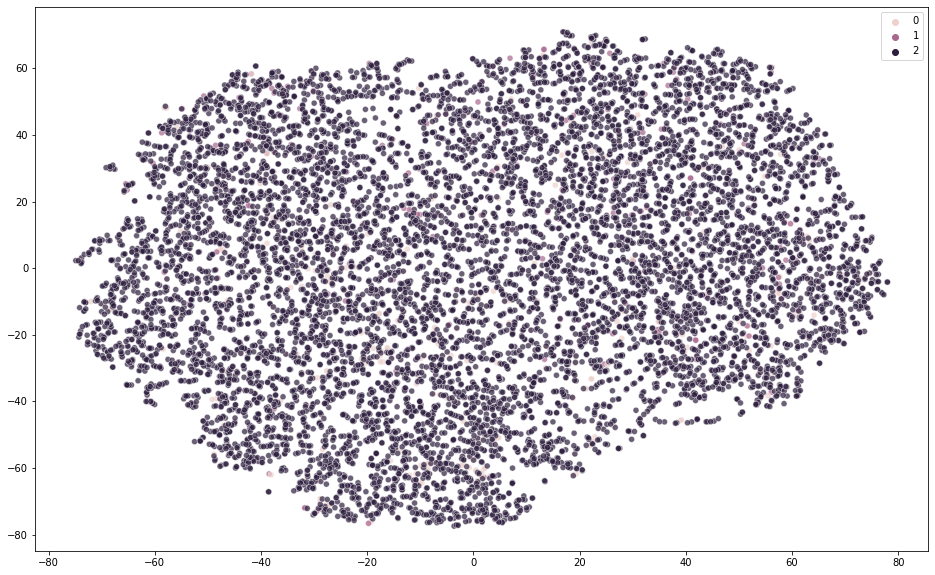

In [19]:
data = X_train
labels = y_train

n_sample = 10000
samples = []
for i in range(n_sample):
    samples.append(model.sample())
samples = np.vstack(samples)

data = np.vstack((data, samples))
labels = np.vstack((labels, np.full((n_sample, 1), 2)))

tsne = TSNE(n_components=2, random_state=1356)
vis_points = tsne.fit_transform(data)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=vis_points[:,0], y=vis_points[:,1], hue=labels.ravel(), legend="full", alpha=0.7
)
plt.show()

### Podejscie drugie 

klasteryzacja danych poszczególnych klas osobno

In [35]:
n_dims = X_train.shape[1]
y_train_flat = y_train.ravel()
X_train_y1 = X_train[y_train_flat == 0]
X_train_y2 = X_train[y_train_flat == 1]
len(X_train_y1), len(X_train_y2)

(401, 213)

#### Znajdz najlepszą liczbę komponentów k

In [36]:
# Znajdz najlepszą liczbę komponentów
def find_best_k(data, max_k = 20):
    n_dims = data.shape[1]
    
    log_dict = {"components": [], "aic": [], "bic": [], "log_likelihood": []}
    for k in range(1, max_k + 1):
        print(f"Training for {k} components")
        try:
            model = GaussianMixtureModelKMeans(n_components = k, n_dims=n_dims, n_epochs=100, verbose=False)
            model.fit(data, random_state=65)
            log_dict["components"].append(k)
            log_dict["log_likelihood"].append(data.shape[0] * max(model.history["log_likelihood"]))
            log_dict["aic"].append(model.aic(data))
            log_dict["bic"].append(model.bic(data))
        except Exception as e:
            print(f"Exception during training: {e}")
    df = pd.DataFrame(log_dict)
    df.plot("components", ["aic", "bic", "log_likelihood"])
    plt.show()
    
    return df

Training for 1 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 2 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 3 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 4 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 5 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 6 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 7 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 8 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 9 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 10 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 11 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 12 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 13 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 14 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 15 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 16 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 17 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 18 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 19 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 20 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite


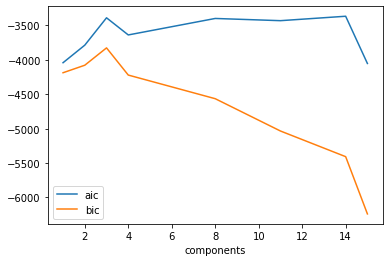

,components,aic,bic,log_likelihood
0,1,-4040.899125,-4186.678717,"tensor(-1591127.5490, dtype=torch.float64)"
1,2,-3785.881979,-4077.441163,"tensor(-1459592.6735, dtype=torch.float64)"
2,3,-3388.192779,-3825.531556,"tensor(-1202015.9305, dtype=torch.float64)"
3,4,-3637.331613,-4220.449981,"tensor(-1297536.4203, dtype=torch.float64)"
4,8,-3397.763492,-4564.000229,"tensor(-820413.4160, dtype=torch.float64)"
5,11,-3429.957214,-5033.532727,"tensor(-821004.0218, dtype=torch.float64)"
6,14,-3365.554584,-5406.468873,"tensor(-799966.7300, dtype=torch.float64)"
7,15,-4051.939025,-6238.632906,"tensor(-782482.6132, dtype=torch.float64)"


In [37]:
find_best_k(X_train_y1)

Training for 1 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 2 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 3 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 4 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 5 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 6 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 7 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 8 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 9 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 10 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 11 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 12 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 13 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 14 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 15 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 16 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 17 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 18 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 19 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 20 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite


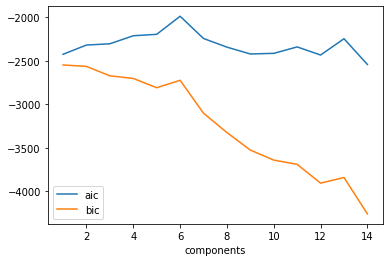

,components,aic,bic,log_likelihood
0,1,-2426.243785,-2548.930949,"tensor(-501240.9262, dtype=torch.float64)"
1,2,-2320.022626,-2565.396954,"tensor(-382139.8110, dtype=torch.float64)"
2,3,-2305.455100,-2673.516592,"tensor(-375343.6896, dtype=torch.float64)"
3,4,-2213.298743,-2704.047400,"tensor(-302471.9706, dtype=torch.float64)"
4,5,-2196.953065,-2810.388885,"tensor(-359725.8873, dtype=torch.float64)"
5,6,-1989.051242,-2725.174227,"tensor(-291447.3102, dtype=torch.float64)"
6,7,-2244.577982,-3103.388130,"tensor(-348658.5477, dtype=torch.float64)"
7,8,-2344.140604,-3325.637916,"tensor(-329966.8513, dtype=torch.float64)"
8,9,-2422.771104,-3526.955580,"tensor(-320637.5913, dtype=torch.float64)"
9,10,-2415.448199,-3642.319839,"tensor(-325492.9478, dtype=torch.float64)"


In [38]:
find_best_k(X_train_y2)

#### Trening używając znalezionych k

In [39]:
# best k's
k_y1 = 3
k_y2 = 6

In [40]:
model_y1 = GaussianMixtureModelKMeans(n_components=k_y1, n_dims=n_dims, n_epochs=100)
model_y2 = GaussianMixtureModelKMeans(n_components=k_y2, n_dims=n_dims, n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.


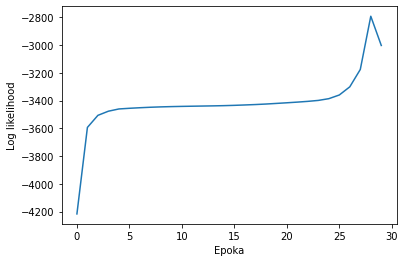

In [41]:
model_y1.fit(X_train_y1)

  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.


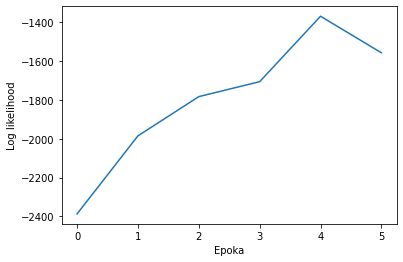

In [42]:
model_y2.fit(X_train_y2)

In [50]:
y_pred_probs_y1 = model_y1.pdf(X_test).numpy()
y_pred_probs_y2 = model_y2.pdf(X_test).numpy()
np.column_stack((y_pred_probs_y1, y_pred_probs_y2))

array([[1.18527596e-05, 1.11721392e-05],
       [3.36323603e-04, 1.40470549e-01],
       [4.40250506e-06, 6.45212771e-04],
       [9.19354800e-03, 4.73518157e-03],
       [2.24053205e-04, 2.36744672e-05],
       [5.50753443e-10, 4.17834781e-06],
       [3.63556994e-03, 2.43691866e-05],
       [5.94888661e-05, 1.50062762e-09],
       [3.06659332e-03, 1.27489902e-05],
       [1.07598120e-04, 1.22908768e-05],
       [3.21335096e-06, 4.73605032e-05],
       [4.35110321e-03, 3.53218602e-05],
       [8.12351063e-05, 1.59927789e-04],
       [1.70387630e-03, 2.98241532e-04],
       [2.87481886e-03, 3.88644139e-06],
       [7.21698598e-05, 5.23172093e-05],
       [9.57117826e-02, 7.26094246e-01],
       [2.32704751e-05, 2.53198040e-03],
       [9.27143916e-02, 1.43288851e-01],
       [4.50355990e-04, 1.05431713e-01],
       [7.50752240e-02, 1.16640357e-02],
       [1.02257188e-02, 1.16614124e-03],
       [1.07189326e-26, 6.28275836e-17],
       [1.32193863e-01, 2.52511024e-01],
       [1.192583

In [51]:
y_pred = (y_pred_probs_y2 > y_pred_probs_y1) * np.ones((X_test.shape[0]))

In [52]:
y_pred

array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1.])

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71        99
           1       0.51      0.64      0.56        55

    accuracy                           0.65       154
   macro avg       0.64      0.65      0.64       154
weighted avg       0.67      0.65      0.66       154

